In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tqdm import tqdm
from collections import Counter
import seaborn as sns
import glob
import pickle
np.random.seed(42)
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GaussianNoise, Reshape, Lambda, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Activation, LSTM, GRU, Bidirectional
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Normalization
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from tensorflow.keras.models import load_model

np.random.seed(42)
tf.random.set_seed(100)

In [3]:
data_folder = 'My Drive/kaggle_bird_species'
tp_df = pd.read_csv(os.path.join(data_folder, 'train_tp.csv'))
tp_df.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70


In [4]:
tp_X = np.load(os.path.join(data_folder, 'tp_specs.npy'))
tp_X.shape

(1216, 90, 938)

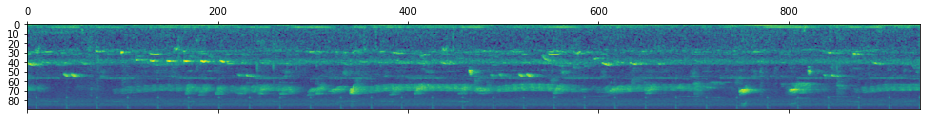

In [5]:
spec1 = tp_X[0,:,:]
plt.matshow(spec1)

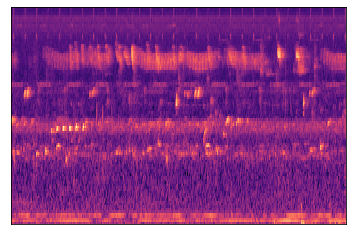

In [6]:
import librosa, librosa.display
librosa.display.specshow(spec1, sr = 48000)

In [7]:
spec1 = spec1[...,np.newaxis]
spec2 = tf.image.resize(spec1, (200,200))
spec2.shape

TensorShape([200, 200, 1])

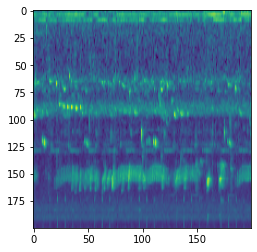

In [8]:
plt.imshow(spec2[:,:,0])

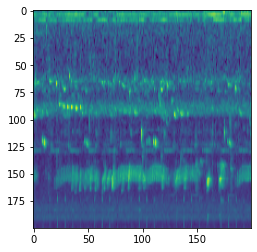

In [9]:
img = Resizing(200,200)(spec1)
plt.imshow(img[:,:,0])

In [10]:
y_labels = tp_df['species_id'].values
y = to_categorical(y_labels, num_classes=24)
print (tp_X.shape, y.shape)

(1216, 90, 938) (1216, 24)


In [11]:
class_weight = compute_class_weight('balanced',np.arange(24), y_labels)
class_weights = dict(zip(np.arange(24), class_weight))
class_weights 

{0: 1.0133333333333334,
 1: 1.0133333333333334,
 2: 1.3693693693693694,
 3: 1.0133333333333334,
 4: 1.0133333333333334,
 5: 1.0133333333333334,
 6: 1.0133333333333334,
 7: 1.0133333333333334,
 8: 1.0133333333333334,
 9: 1.4901960784313726,
 10: 1.0133333333333334,
 11: 1.0133333333333334,
 12: 1.0133333333333334,
 13: 1.0133333333333334,
 14: 1.0133333333333334,
 15: 1.0133333333333334,
 16: 1.0133333333333334,
 17: 0.7450980392156863,
 18: 1.0133333333333334,
 19: 1.178294573643411,
 20: 1.2666666666666666,
 21: 1.0133333333333334,
 22: 1.1515151515151516,
 23: 0.5066666666666667}

#**CNN model ony**

In [ ]:

def create_model(input_shape = (90,938,1)):
  model = Sequential()
  model.add(Input(shape = input_shape))
  model.add(Resizing(200,200))
  
  model.add(Conv2D(32, (3,3), kernel_initializer = 'he_normal', padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  


  model.add(Conv2D(64, kernel_size = (3,3),  padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, kernel_size = (3,3), padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(256, kernel_size = (3,3), padding = 'same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))


  model.add(Flatten())

  model.add(Dense(512, kernel_initializer = 'he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.3))

  model.add(Dense(24, activation = 'softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['acc'])
  model.summary()
  return model

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(tp_X, y, test_size = 0.2,
                                                      stratify = y_labels, shuffle = True,
                                                      random_state = 42)
x_train = x_train[..., np.newaxis]
x_valid = x_valid[..., np.newaxis]
print (x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(972, 90, 938, 1) (972, 24) (244, 90, 938, 1) (244, 24)


In [ ]:
model = create_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_3 (Resizing)        (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 200, 200, 32)      320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 200, 200, 32)      128       
_________________________________________________________________
activation_5 (Activation)    (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 100, 100, 64)     

In [ ]:
model_checkpoint = os.path.join(data_folder,'models','tp_model.hdf5')

cp = ModelCheckpoint(model_checkpoint, monitor='val_loss', verbose=1, save_best_only=True)

lr = ReduceLROnPlateau(
      monitor='val_loss', factor=0.3, patience=10, verbose=0,
      mode='auto'
)

callbacks = [cp, lr]
history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid),
                    epochs = 50, batch_size = 32, callbacks = callbacks, 
                    class_weight = class_weights)

Epoch 1/50
31/31 [==============================] - 3s 83ms/step - loss: 3.0457 - acc: 0.1872 - val_loss: 12.7832 - val_acc: 0.0779

Epoch 00001: val_loss improved from inf to 12.78319, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 2/50
31/31 [==============================] - 2s 81ms/step - loss: 1.5153 - acc: 0.5430 - val_loss: 2.5970 - val_acc: 0.3074

Epoch 00002: val_loss improved from 12.78319 to 2.59698, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 3/50
31/31 [==============================] - 2s 77ms/step - loss: 0.6890 - acc: 0.7790 - val_loss: 1.9909 - val_acc: 0.4508

Epoch 00003: val_loss improved from 2.59698 to 1.99093, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 4/50
31/31 [==============================] - 2s 78ms/step - loss: 0.4039 - acc: 0.8844 - val_loss: 1.5040 - val_acc: 0.5861

Epoch 00004: val_loss improved from 1.99093 to 1.50400, saving model to My Drive/kaggle_bird_species/models

In [24]:
def plot_history(history):
    fig,axs = plt.subplots(1,2, figsize = (15,6))
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set_title('model accuracy')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('model loss')
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper right')
    
    plt.show()

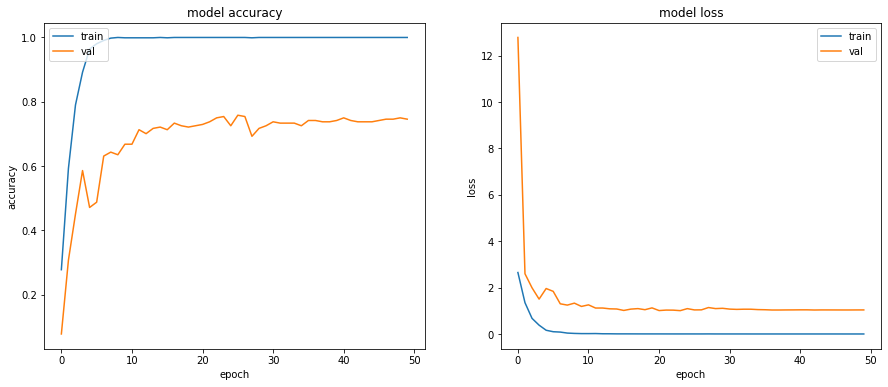

In [ ]:
plot_history(history)

In [ ]:
model = load_model(model_checkpoint)

In [ ]:
model.evaluate(x_valid, y_valid)

8/8 [==============================] - 0s 26ms/step - loss: 1.0067 - acc: 0.7541


[1.006690502166748, 0.7540983557701111]

In [ ]:
y_pred = np.argmax(model.predict(x_valid),axis = 1)
y_true = np.argmax(y_valid, axis = 1)
print (classification_report(y_true,y_pred ))

              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       1.00      0.60      0.75        10
           2       0.83      0.71      0.77         7
           3       0.55      0.60      0.57        10
           4       0.71      0.50      0.59        10
           5       0.62      0.80      0.70        10
           6       0.83      1.00      0.91        10
           7       0.56      0.50      0.53        10
           8       0.86      0.60      0.71        10
           9       1.00      0.86      0.92         7
          10       0.82      0.90      0.86        10
          11       0.80      0.80      0.80        10
          12       0.70      0.70      0.70        10
          13       0.78      0.70      0.74        10
          14       0.75      0.60      0.67        10
          15       0.78      0.70      0.74        10
          16       1.00      0.90      0.95        10
          17       0.81    

#**RNN model only**

For RNN, the input is expected in the format (batch, timestep, features). So we have to do the necessary transformation, that is, take the transpose of each spectrogram.

In [13]:
print (tp_X.shape)
tp_X = tp_X.reshape(tp_X.shape[0], tp_X.shape[2], tp_X.shape[1])
print (tp_X.shape)

(1216, 90, 938)
(1216, 938, 90)


In [14]:
input_shape = (tp_X.shape[1], tp_X.shape[2])

In [32]:
model = Sequential()
model.add(Input(input_shape))
model.add(Normalization())
model.add(Bidirectional(LSTM(90, kernel_initializer = 'he_normal', return_sequences=True)))
model.add(BatchNormalization())

model.add(Bidirectional(LSTM(90, kernel_initializer = 'he_normal', return_sequences=True)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(512, kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(24, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['acc'])
model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_6 (Normalizati (None, 938, 90)           181       
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 938, 180)          130320    
_________________________________________________________________
batch_normalization_25 (Batc (None, 938, 180)          720       
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 938, 180)          195120    
_________________________________________________________________
batch_normalization_26 (Batc (None, 938, 180)          720       
_________________________________________________________________
flatten_2 (Flatten)          (None, 168840)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)              

In [33]:
x_train, x_valid, y_train, y_valid = train_test_split(tp_X, y, test_size = 0.2,
                                                      stratify = y_labels, shuffle = True,
                                                      random_state = 42)

print (x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(972, 938, 90) (972, 24) (244, 938, 90) (244, 24)


In [34]:
model_checkpoint = os.path.join(data_folder,'models','tp_model.hdf5')

cp = ModelCheckpoint(model_checkpoint, monitor='val_loss', verbose=1, save_best_only=True)

lr = ReduceLROnPlateau(
      monitor='val_loss', factor=0.3, patience=10, verbose=0,
      mode='auto'
)

callbacks = [cp, lr]

history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid),
                    epochs = 70, batch_size = 32, callbacks = callbacks, 
                    class_weight = class_weights)

Epoch 1/70
31/31 [==============================] - 13s 253ms/step - loss: 3.6579 - acc: 0.1254 - val_loss: 4.0996 - val_acc: 0.0738

Epoch 00001: val_loss improved from inf to 4.09959, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 2/70
31/31 [==============================] - 7s 223ms/step - loss: 1.7263 - acc: 0.4641 - val_loss: 3.7253 - val_acc: 0.0820

Epoch 00002: val_loss improved from 4.09959 to 3.72527, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 3/70
31/31 [==============================] - 7s 215ms/step - loss: 0.5897 - acc: 0.8658 - val_loss: 3.1598 - val_acc: 0.1352

Epoch 00003: val_loss improved from 3.72527 to 3.15982, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 4/70
31/31 [==============================] - 7s 216ms/step - loss: 0.1004 - acc: 0.9952 - val_loss: 2.9773 - val_acc: 0.1475

Epoch 00004: val_loss improved from 3.15982 to 2.97728, saving model to My Drive/kaggle_bird_species/mode

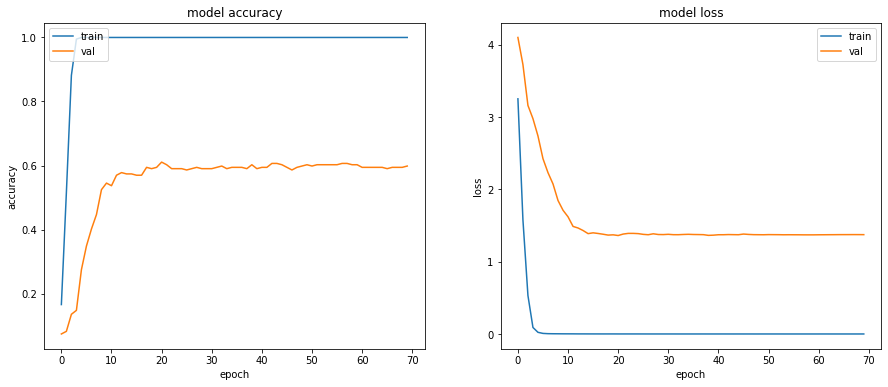

In [35]:
plot_history(history)

RNN model only achieves around 61% val accuracy.

#**Model with both CNN and LSTM**

**Model 1: RNN in first layer before CNN**

In [67]:
#Input shape (938,90,1) if first extracting feature by conv else (938,90) if first layer is RNN layer
def create_model(input_shape = (938,90)):
  model = Sequential()
  model.add(Input(input_shape))
  model.add(Normalization())
  
  model.add(Bidirectional(LSTM(90, kernel_initializer = 'he_normal', return_sequences= True)))
  model.add(BatchNormalization())


  model.add(Lambda(lambda x:tf.expand_dims(x, axis = -1)))
  
  model.add(Resizing(200,200))
  
  model.add(Conv2D(64, (3,3), kernel_initializer = 'he_normal', padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  


  model.add(Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(256, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))

  '''model.add(Conv2D(256, (1,1)))
  model.add(Conv2D(32,(1,1)))
  model.add(Conv2D(1,(1,1)))
  
  model.add(Reshape((12,12)))

  model.add(Bidirectional(LSTM(units = 12, return_sequences=True)))
  #model.add(LSTM(12))
  '''
  model.add(Flatten())

  model.add(Dense(512, kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.3))

  model.add(Dense(24, kernel_initializer = 'he_normal', activation = 'softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['acc'])
  model.summary()
  return model

In [68]:
model = create_model()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_17 (Normalizat (None, 938, 90)           181       
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 938, 180)          130320    
_________________________________________________________________
batch_normalization_92 (Batc (None, 938, 180)          720       
_________________________________________________________________
lambda_6 (Lambda)            (None, 938, 180, 1)       0         
_________________________________________________________________
resizing_9 (Resizing)        (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 200, 200, 64)      640       
_________________________________________________________________
batch_normalization_93 (Batc (None, 200, 200, 64)    

In [69]:
x_train, x_valid, y_train, y_valid = train_test_split(tp_X, y, test_size = 0.2,
                                                      stratify = y_labels, shuffle = True,
                                                      random_state = 42)

print (x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(972, 938, 90) (972, 24) (244, 938, 90) (244, 24)


In [70]:
model_checkpoint = os.path.join(data_folder,'models','tp_model.hdf5')

cp = ModelCheckpoint(model_checkpoint, monitor='val_loss', verbose=1, save_best_only=True)

lr = ReduceLROnPlateau(
      monitor='val_loss', factor=0.3, patience=10, verbose=0,
      mode='auto'
)

callbacks = [cp, lr]

history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid),
                    epochs = 70, batch_size = 32, callbacks = callbacks, 
                    class_weight = class_weights)

Epoch 1/70
31/31 [==============================] - 9s 195ms/step - loss: 3.3843 - acc: 0.0944 - val_loss: 3.1492 - val_acc: 0.0697

Epoch 00001: val_loss improved from inf to 3.14924, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 2/70
31/31 [==============================] - 5s 154ms/step - loss: 2.3636 - acc: 0.2785 - val_loss: 3.1185 - val_acc: 0.0861

Epoch 00002: val_loss improved from 3.14924 to 3.11845, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 3/70
31/31 [==============================] - 5s 153ms/step - loss: 1.8208 - acc: 0.4425 - val_loss: 3.2775 - val_acc: 0.1516

Epoch 00003: val_loss did not improve from 3.11845
Epoch 4/70
31/31 [==============================] - 5s 155ms/step - loss: 1.4289 - acc: 0.5421 - val_loss: 3.9662 - val_acc: 0.0656

Epoch 00004: val_loss did not improve from 3.11845
Epoch 5/70
31/31 [==============================] - 5s 154ms/step - loss: 1.2607 - acc: 0.5824 - val_loss: 3.3183 - val_acc: 0

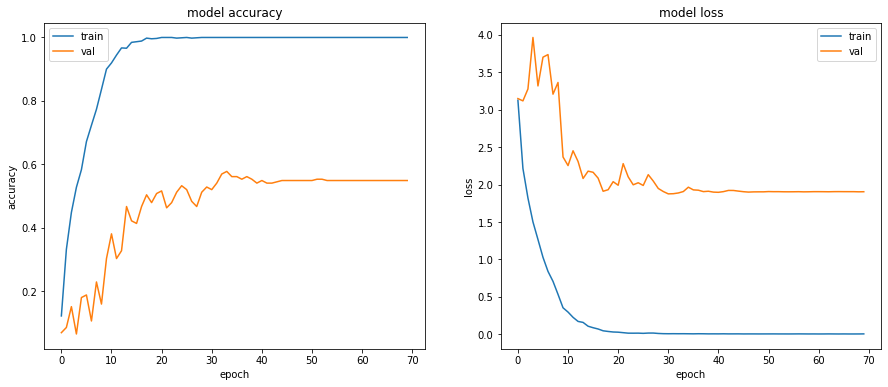

In [71]:
plot_history(history)

**Model 2: Applying RNN component after feature map of Convolution blocks**

In [72]:
def create_model(input_shape = (938,90,1)):
  model = Sequential()
  model.add(Input(input_shape))
  model.add(Normalization())
  
  #model.add(Bidirectional(LSTM(90, kernel_initializer = 'he_normal', return_sequences= True)))
  #model.add(BatchNormalization())

  #model.add(Bidirectional(LSTM(90, kernel_initializer = 'he_normal', return_sequences= True)))
  #model.add(BatchNormalization())

  #model.add(Lambda(lambda x:tf.expand_dims(x, axis = -1)))
  model.add(Resizing(200,200))
  
  model.add(Conv2D(64, (3,3), kernel_initializer = 'he_normal', padding = 'same'))
  #model.add(GaussianNoise(0.3))
  #model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  


  model.add(Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  #model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(256, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  #model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))

  
  model.add(Conv2D(128,(1,1), kernel_initializer = 'he_normal'))
  model.add(Conv2D(1,(1,1), kernel_initializer = 'he_normal'))
  model.add(BatchNormalization())
 
  model.add(Reshape((100,100)))

  model.add(Bidirectional(LSTM(units = 100, kernel_initializer = 'he_normal', return_sequences=True)))
  model.add(BatchNormalization()) 

  model.add(Bidirectional(LSTM(units = 100, kernel_initializer = 'he_normal', return_sequences=True)))
  model.add(BatchNormalization()) 
  
  model.add(Flatten())

  model.add(Dense(512, kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.3))

  model.add(Dense(24, kernel_initializer = 'he_normal', activation = 'softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['acc'])
  model.summary()
  
  return model

In [73]:
model = create_model()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_18 (Normalizat (None, 938, 90, 1)        3         
_________________________________________________________________
resizing_10 (Resizing)       (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 200, 200, 64)      640       
_________________________________________________________________
activation_57 (Activation)   (None, 200, 200, 64)      0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 100, 100, 128)     73856     
_________________________________________________________________
batch_normalization_98 (Batc (None, 100, 100, 128)   

In [74]:
model_checkpoint = os.path.join(data_folder,'models','tp_model.hdf5')

cp = ModelCheckpoint(model_checkpoint, monitor='val_loss', verbose=1, save_best_only=True)

lr = ReduceLROnPlateau(
      monitor='val_loss', factor=0.3, patience=10, verbose=0,
      mode='auto'
)

callbacks = [cp, lr]

history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid),
                    epochs = 70, batch_size = 32, callbacks = callbacks, 
                    class_weight = class_weights)

Epoch 1/70
31/31 [==============================] - 12s 198ms/step - loss: 3.4286 - acc: 0.1577 - val_loss: 4.7269 - val_acc: 0.0779

Epoch 00001: val_loss improved from inf to 4.72691, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 2/70
31/31 [==============================] - 5s 149ms/step - loss: 1.6083 - acc: 0.5367 - val_loss: 4.2407 - val_acc: 0.0164

Epoch 00002: val_loss improved from 4.72691 to 4.24074, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 3/70
31/31 [==============================] - 5s 156ms/step - loss: 0.7573 - acc: 0.7817 - val_loss: 3.7432 - val_acc: 0.0451

Epoch 00003: val_loss improved from 4.24074 to 3.74316, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 4/70
31/31 [==============================] - 5s 149ms/step - loss: 0.3358 - acc: 0.9273 - val_loss: 4.4255 - val_acc: 0.0410

Epoch 00004: val_loss did not improve from 3.74316
Epoch 5/70
31/31 [==============================] - 5s

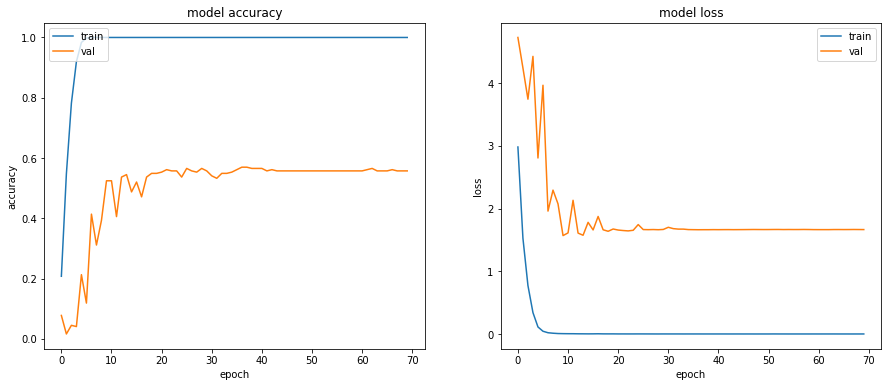

In [75]:
plot_history(history)

**Model 3: CNN, RNN, Parallely and finally merging the two before final layer**

In [99]:
def rnn_model(input_shape = (938,90)):
  model = Sequential()
  model.add(Input(input_shape))
  model.add(Normalization())
  model.add(Bidirectional(LSTM(90, kernel_initializer = 'he_normal', return_sequences=True)))
  model.add(BatchNormalization())

  model.add(Bidirectional(LSTM(90, kernel_initializer = 'he_normal', return_sequences=True)))
  model.add(BatchNormalization())

  model.add(Flatten())

  model.add(Dense(512, kernel_initializer = 'he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.3))

  #model.summary()
  return model

def cnn_model(input_shape = (938,90)):
  model = Sequential()
  model.add(Input(input_shape))
  #model.add(Normalization())

  model.add(Lambda(lambda x:tf.expand_dims(x, axis = -1)))
  
  model.add(Resizing(200,200))
  
  model.add(Conv2D(64, (3,3), kernel_initializer = 'he_normal', padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  


  model.add(Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(256, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))

  model.add(Flatten())

  model.add(Dense(512, kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.3))

  #model.summary()
  return model

def create_model(input_shape = (938,90)):

  x = Input(input_shape)
  rnn = rnn_model()(x)
  print (rnn.shape)
  cnn = cnn_model()(x)
  print (cnn.shape)
  feature_map = Concatenate()([cnn,rnn])
  output = Dense(24, input_shape = (512*2,), kernel_initializer = 'he_normal', activation = 'softmax')(feature_map)
  
  model = Model(x, output)

  model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['acc'])
  model.summary()

  return model

In [100]:
model = create_model()

(None, 512)
(None, 512)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 938, 90)]    0                                            
__________________________________________________________________________________________________
sequential_35 (Sequential)      (None, 512)          19285568    input_35[0][0]                   
__________________________________________________________________________________________________
sequential_34 (Sequential)      (None, 512)          86775701    input_35[0][0]                   
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 1024)         0           sequential_35[0][0]              
                                                                 seq

In [101]:
model_checkpoint = os.path.join(data_folder,'models','tp_model.hdf5')

cp = ModelCheckpoint(model_checkpoint, monitor='val_loss', verbose=1, save_best_only=True)

lr = ReduceLROnPlateau(
      monitor='val_loss', factor=0.3, patience=10, verbose=0,
      mode='auto'
)

callbacks = [cp, lr]

history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid),
                    epochs = 70, batch_size = 32, callbacks = callbacks, 
                    class_weight = class_weights)

Epoch 1/70
31/31 [==============================] - 15s 310ms/step - loss: 3.4837 - acc: 0.1669 - val_loss: 29.9149 - val_acc: 0.0697

Epoch 00001: val_loss improved from inf to 29.91490, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 2/70
31/31 [==============================] - 8s 260ms/step - loss: 1.4057 - acc: 0.5803 - val_loss: 6.2334 - val_acc: 0.1475

Epoch 00002: val_loss improved from 29.91490 to 6.23341, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 3/70
31/31 [==============================] - 8s 260ms/step - loss: 0.5522 - acc: 0.8129 - val_loss: 3.1327 - val_acc: 0.2213

Epoch 00003: val_loss improved from 6.23341 to 3.13269, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 4/70
31/31 [==============================] - 8s 260ms/step - loss: 0.2167 - acc: 0.9502 - val_loss: 2.5081 - val_acc: 0.3566

Epoch 00004: val_loss improved from 3.13269 to 2.50809, saving model to My Drive/kaggle_bird_species/m

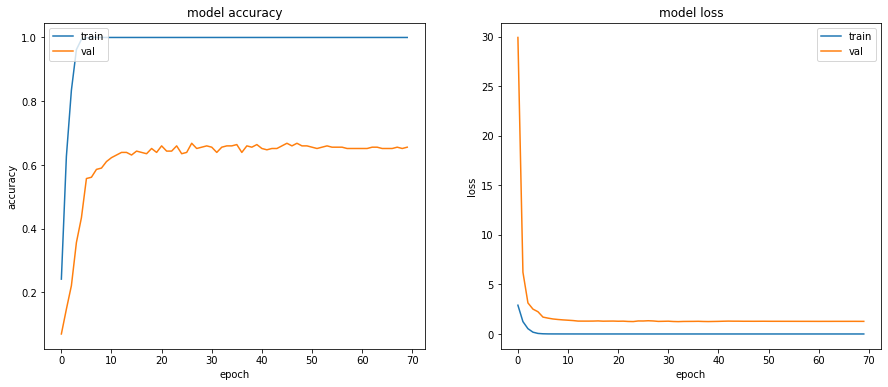

In [102]:
plot_history(history)

#**Proceeding with CNN model**

A CNN model seems to be giving the best performance among the other architectures and so we proceed with that.

In [ ]:
@tf.function
def _one_sample_positive_class_precisions(example):
    y_true, y_pred = example

    retrieved_classes = tf.argsort(y_pred, direction='DESCENDING')
    class_rankings = tf.argsort(retrieved_classes)
    retrieved_class_true = tf.gather(y_true, retrieved_classes)
    retrieved_cumulative_hits = tf.math.cumsum(tf.cast(retrieved_class_true, tf.float32))

    idx = tf.where(y_true)[:, 0]
    i = tf.boolean_mask(class_rankings, y_true)
    r = tf.gather(retrieved_cumulative_hits, i)
    c = 1 + tf.cast(i, tf.float32)
    precisions = r / c

    dense = tf.scatter_nd(idx[:, None], precisions, [y_pred.shape[0]])
    return dense

class LWLRAP(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='lwlrap'):
        super().__init__(name=name)

        self._precisions = self.add_weight(
            name='per_class_cumulative_precision',
            shape=[num_classes],
            initializer='zeros',
        )

        self._counts = self.add_weight(
            name='per_class_cumulative_count',
            shape=[num_classes],
            initializer='zeros',
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        precisions = tf.map_fn(
            fn=_one_sample_positive_class_precisions,
            elems=(y_true, y_pred),
            dtype=(tf.float32),
        )

        increments = tf.cast(precisions > 0, tf.float32)
        total_increments = tf.reduce_sum(increments, axis=0)
        total_precisions = tf.reduce_sum(precisions, axis=0)

        self._precisions.assign_add(total_precisions)
        self._counts.assign_add(total_increments)        

    def result(self):
        per_class_lwlrap = self._precisions / tf.maximum(self._counts, 1.0)
        per_class_weight = self._counts / tf.reduce_sum(self._counts)
        overall_lwlrap = tf.reduce_sum(per_class_lwlrap * per_class_weight)
        return overall_lwlrap

    def reset_states(self):
        self._precisions.assign(self._precisions * 0)
        self._counts.assign(self._counts * 0)

In [ ]:
def create_model(input_shape = (90,938,1)):
  model = Sequential()
  model.add(Input(shape = input_shape))
  model.add(Resizing(200,200))
  
  model.add(Conv2D(32, (3,3), kernel_initializer = 'he_normal', padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  


  model.add(Conv2D(64, kernel_size = (3,3),  padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, kernel_size = (3,3), padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(256, kernel_size = (3,3), padding = 'same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))


  model.add(Flatten())

  model.add(Dense(512, kernel_initializer = 'he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.3))

  model.add(Dense(24, activation = 'softmax'))
  
  model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['acc', LWLRAP(24)])
  model.summary()
  return model

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(tp_X, y, test_size = 0.2,
                                                      stratify = y_labels, shuffle = True,
                                                      random_state = 42)

print (x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(972, 90, 938) (972, 24) (244, 90, 938) (244, 24)


In [ ]:
model = create_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_4 (Resizing)        (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 200, 200, 32)      320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 200, 200, 32)      128       
_________________________________________________________________
activation_10 (Activation)   (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 100, 100, 64)     

In [ ]:
model_checkpoint = os.path.join(data_folder,'models','tp_model.hdf5')

cp = ModelCheckpoint(model_checkpoint, monitor='val_loss', verbose=1, save_best_only=True)

lr = ReduceLROnPlateau(
      monitor='val_loss', factor=0.3, patience=10, verbose=0,
      mode='auto'
)

callbacks = [cp, lr]

history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid),
                    epochs = 50, batch_size = 32, callbacks = callbacks, 
                    class_weight = class_weights)

Epoch 1/50
Instructions for updating:
Use fn_output_signature instead
31/31 [==============================] - 5s 111ms/step - loss: 3.1859 - acc: 0.1877 - lwlrap: 0.3389 - val_loss: 11.9301 - val_acc: 0.0656 - val_lwlrap: 0.1993

Epoch 00001: val_loss improved from inf to 11.93006, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 2/50
31/31 [==============================] - 3s 100ms/step - loss: 1.4159 - acc: 0.5650 - lwlrap: 0.7072 - val_loss: 2.6936 - val_acc: 0.3033 - val_lwlrap: 0.4405

Epoch 00002: val_loss improved from 11.93006 to 2.69362, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 3/50
31/31 [==============================] - 3s 101ms/step - loss: 0.7140 - acc: 0.7904 - lwlrap: 0.8678 - val_loss: 2.4511 - val_acc: 0.3893 - val_lwlrap: 0.5357

Epoch 00003: val_loss improved from 2.69362 to 2.45105, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 4/50
31/31 [==============================] - 3s 109ms/st

In [ ]:
def plot_history(history):
    fig,axs = plt.subplots(1,3, figsize = (15,6))

    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set_title('model accuracy')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    
    axs[1].plot(history.history['lwlrap'])
    axs[1].plot(history.history['val_lwlrap'])
    axs[1].set_title('model lwlrap')
    axs[1].set_ylabel('LWLRAP')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')

    axs[2].plot(history.history['loss'])
    axs[2].plot(history.history['val_loss'])
    axs[2].set_title('model loss')
    axs[2].set_ylabel('loss')
    axs[2].set_xlabel('epoch')
    axs[2].legend(['train', 'val'], loc='upper right')
    
    plt.show()

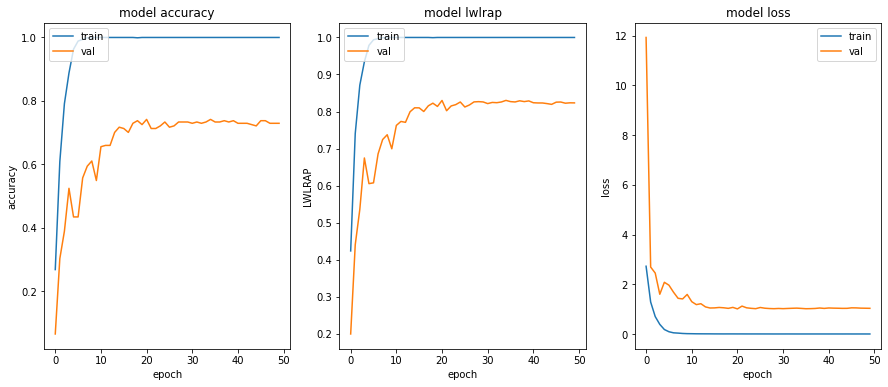

In [ ]:
plot_history(history)

In [ ]:
def create_model(input_shape = (90,938,1)):
  model = Sequential()
  model.add(Input(shape = input_shape))
  model.add(Resizing(200,200))
  
  model.add(Conv2D(32, (3,3), kernel_initializer = 'he_normal', padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  


  model.add(Conv2D(64, kernel_size = (3,3),  padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, kernel_size = (3,3), padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(256, kernel_size = (3,3), padding = 'same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))


  model.add(Flatten())

  model.add(Dense(512, kernel_initializer = 'he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.3))

  model.add(Dense(24, activation = 'softmax'))
  
  model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = [LWLRAP(24)])
  model.summary()
  return model

In [ ]:
model = create_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_3 (Resizing)        (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 200, 200, 32)      320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 200, 200, 32)      128       
_________________________________________________________________
activation_10 (Activation)   (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 100, 100, 64)     

In [ ]:
model_checkpoint = os.path.join(data_folder,'models','tp_model.hdf5')

cp = ModelCheckpoint(model_checkpoint, monitor='val_loss', verbose=1, save_best_only=True)

lr = ReduceLROnPlateau(
      monitor='val_loss', factor=0.3, patience=10, verbose=0,
      mode='auto'
)

callbacks = [cp, lr]

history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid),
                    epochs = 70, batch_size = 32, callbacks = callbacks, 
                    class_weight = class_weights)

Epoch 1/70
31/31 [==============================] - 4s 112ms/step - loss: 0.4494 - lwlrap: 0.2506 - val_loss: 0.8307 - val_lwlrap: 0.1637

Epoch 00001: val_loss improved from inf to 0.83073, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 2/70
31/31 [==============================] - 3s 103ms/step - loss: 0.1199 - lwlrap: 0.5942 - val_loss: 0.2960 - val_lwlrap: 0.2108

Epoch 00002: val_loss improved from 0.83073 to 0.29600, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 3/70
31/31 [==============================] - 3s 105ms/step - loss: 0.0803 - lwlrap: 0.7814 - val_loss: 0.1627 - val_lwlrap: 0.4329

Epoch 00003: val_loss improved from 0.29600 to 0.16266, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 4/70
31/31 [==============================] - 3s 103ms/step - loss: 0.0552 - lwlrap: 0.8785 - val_loss: 0.1826 - val_lwlrap: 0.5275

Epoch 00004: val_loss did not improve from 0.16266
Epoch 5/70
31/31 [=============

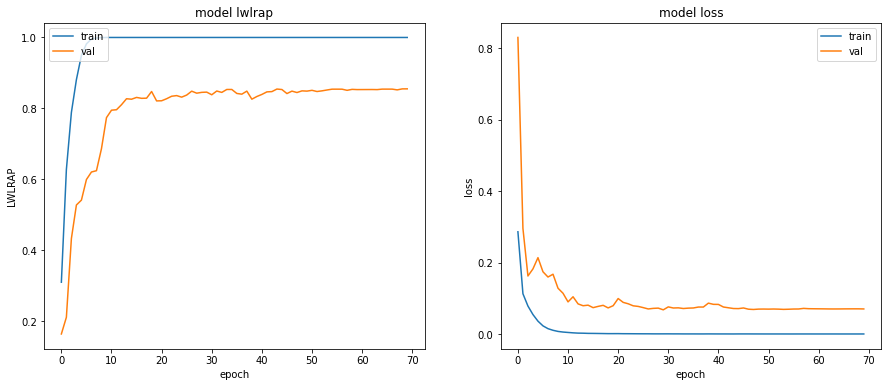

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (15,6))
axs[0].plot(history.history['lwlrap'])
axs[0].plot(history.history['val_lwlrap'])
axs[0].set_title('model lwlrap')
axs[0].set_ylabel('LWLRAP')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'val'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'], loc='upper right')

plt.show()

In [ ]:
y_pred = model.predict(x_valid)
y_pred = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_valid, axis = 1)
print (classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.71      0.50      0.59        10
           2       0.67      0.86      0.75         7
           3       0.83      0.50      0.62        10
           4       0.78      0.70      0.74        10
           5       0.53      0.80      0.64        10
           6       0.77      1.00      0.87        10
           7       0.62      0.50      0.56        10
           8       0.88      0.70      0.78        10
           9       1.00      0.86      0.92         7
          10       0.90      0.90      0.90        10
          11       0.77      1.00      0.87        10
          12       0.55      0.60      0.57        10
          13       0.88      0.70      0.78        10
          14       0.78      0.70      0.74        10
          15       0.82      0.90      0.86        10
          16       0.82      0.90      0.86        10
          17       0.86    

**Using SigmoidFocalCrossEntropy Loss for data imbalance problem**

In [ ]:
def create_model(input_shape = (90,938,1)):
  model = Sequential()
  model.add(Input(shape = input_shape))
  model.add(Resizing(200,200))
  
  model.add(Conv2D(32, (3,3), kernel_initializer = 'he_normal', padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  


  model.add(Conv2D(64, kernel_size = (3,3),  padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, kernel_size = (3,3), padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(256, kernel_size = (3,3), padding = 'same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))


  model.add(Flatten())

  model.add(Dense(512, kernel_initializer = 'he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.3))

  model.add(Dense(24, activation = 'softmax'))
  
  loss_fn = tfa.losses.SigmoidFocalCrossEntropy(from_logits = True)
  model.compile(loss = loss_fn, optimizer = "adam", metrics = [LWLRAP(24)])
  model.summary()
  return model

In [ ]:
model = create_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 64)      2

In [ ]:
model_checkpoint = os.path.join(data_folder,'models','tp_model.hdf5')

cp = ModelCheckpoint(model_checkpoint, monitor='val_loss', verbose=1, save_best_only=True)

lr = ReduceLROnPlateau(
      monitor='val_loss', factor=0.3, patience=10, verbose=0,
      mode='auto'
)

callbacks = [cp, lr]

history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid),
                    epochs = 70, batch_size = 32, callbacks = callbacks, 
                    class_weight = class_weights)

Epoch 1/70
Instructions for updating:
Use fn_output_signature instead
31/31 [==============================] - 12s 117ms/step - loss: 3.2705 - lwlrap: 0.2642 - val_loss: 3.3419 - val_lwlrap: 0.2304

Epoch 00001: val_loss improved from inf to 3.34191, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 2/70
31/31 [==============================] - 3s 101ms/step - loss: 3.1965 - lwlrap: 0.5438 - val_loss: 3.2482 - val_lwlrap: 0.4253

Epoch 00002: val_loss improved from 3.34191 to 3.24823, saving model to My Drive/kaggle_bird_species/models/tp_model.hdf5
Epoch 3/70
31/31 [==============================] - 3s 103ms/step - loss: 3.1392 - lwlrap: 0.7171 - val_loss: 3.2774 - val_lwlrap: 0.4316

Epoch 00003: val_loss did not improve from 3.24823
Epoch 4/70
31/31 [==============================] - 3s 103ms/step - loss: 3.0638 - lwlrap: 0.8177 - val_loss: 3.1704 - val_lwlrap: 0.6382

Epoch 00004: val_loss improved from 3.24823 to 3.17042, saving model to My Drive/kaggle_bird_

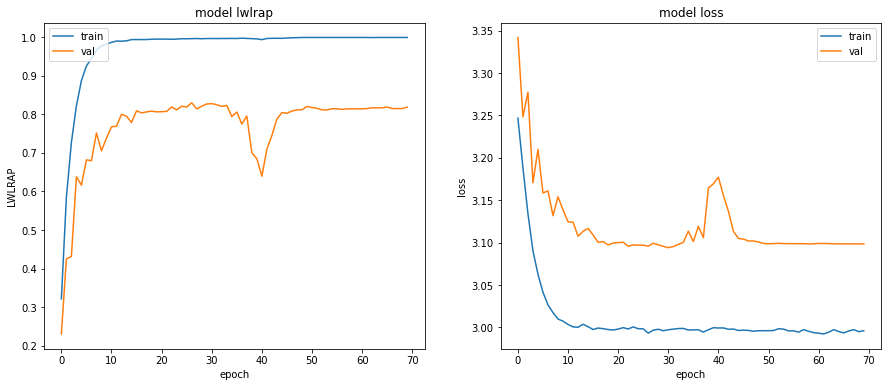

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (15,6))
axs[0].plot(history.history['lwlrap'])
axs[0].plot(history.history['val_lwlrap'])
axs[0].set_title('model lwlrap')
axs[0].set_ylabel('LWLRAP')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'val'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'], loc='upper right')

plt.show()

In [ ]:
y_pred = model.predict(x_valid)
y_pred = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_valid, axis = 1)
print (classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.60      0.63        10
           2       0.70      1.00      0.82         7
           3       0.67      0.40      0.50        10
           4       0.60      0.60      0.60        10
           5       0.67      0.60      0.63        10
           6       1.00      0.90      0.95        10
           7       0.71      0.50      0.59        10
           8       0.70      0.70      0.70        10
           9       0.86      0.86      0.86         7
          10       0.64      0.90      0.75        10
          11       0.82      0.90      0.86        10
          12       0.44      0.70      0.54        10
          13       0.57      0.40      0.47        10
          14       0.55      0.60      0.57        10
          15       0.83      1.00      0.91        10
          16       1.00      0.80      0.89        10
          17       0.71    

#**Predicting in test set**

1) Using the binary cross entropy loss function: Kaggle Score: 0.60

2) Using sigmoidfocal cross entropy loss function: 0.595

In [ ]:
ss = pd.read_csv(os.path.join(data_folder,'sample_submission.csv'))
ss.head()

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,000316da7,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,003bc2cb2,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,0061c037e,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,010eb14d3,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,011318064,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
windows = {}
for i in range(6):
  filename = 'test_{}.npy'.format(i)
  windows[i] = np.load(os.path.join(data_folder,filename))


In [ ]:
for i in range(6):
  print (windows[i].shape)

(1992, 90, 938)
(1992, 90, 938)
(1992, 90, 938)
(1992, 90, 938)
(1992, 90, 938)
(1992, 90, 938)


In [ ]:
preds = {}
for i in range(6):
  preds[i] = model.predict(windows[i])

for i in range(6):
  print (preds[i].shape)

(1992, 24)
(1992, 24)
(1992, 24)
(1992, 24)
(1992, 24)
(1992, 24)


In [ ]:
species_labels = {}
num_species = 24
test_recordings = ss['recording_id'].values

for i in range(num_species):
  label = 's'+str(i)
  species_labels[label] = []

In [ ]:
for i in range(ss.shape[0]):
  for j in range(num_species):
    
    max_prob = 0
    for k in range(6):
      t = preds[k]
      #print (t.shape)
      if t[i,j] > max_prob:
        max_prob = t[i,j]
    
    label = 's' + str(j)
    species_labels[label].append(max_prob)


In [ ]:
for species in species_labels.keys():
  print (species, len(species_labels[species]))


s0 1992
s1 1992
s2 1992
s3 1992
s4 1992
s5 1992
s6 1992
s7 1992
s8 1992
s9 1992
s10 1992
s11 1992
s12 1992
s13 1992
s14 1992
s15 1992
s16 1992
s17 1992
s18 1992
s19 1992
s20 1992
s21 1992
s22 1992
s23 1992


In [ ]:
for species in species_labels.keys():
  ss[species] = species_labels[species]

In [ ]:
ss.head()

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,000316da7,0.061255,0.147134,0.005462,0.971223,0.000574,0.442181,0.009617,0.013888,0.003736,0.533140,0.004322,0.073361,0.960862,0.063811,0.046504,0.045955,0.002369,0.825058,0.072476,0.040915,0.018763,0.080923,0.042626,0.028630
1,003bc2cb2,0.000721,0.000310,0.000109,0.006709,0.001180,0.001472,0.001894,0.000857,0.004740,0.003346,0.000237,0.000372,0.003688,0.017841,0.002077,0.000884,0.999393,0.046007,0.001369,0.004020,0.000375,0.000185,0.001754,0.003406
2,0061c037e,0.116654,0.015915,0.000578,0.027947,0.008943,0.326303,0.014911,0.245989,0.001107,0.604729,0.022158,0.011703,0.000433,0.000299,0.002173,0.015849,0.004682,0.042704,0.001940,0.057644,0.801925,0.003792,0.868528,0.010516
3,010eb14d3,0.418655,0.000105,0.000132,0.000577,0.027743,0.094050,0.004184,0.003761,0.989963,0.026476,0.000991,0.000649,0.015442,0.000374,0.001397,0.000772,0.001855,0.010411,0.726970,0.002640,0.000577,0.000768,0.014695,0.019635
4,011318064,0.006484,0.093153,0.001453,0.946304,0.000274,0.122612,0.266433,0.004865,0.003635,0.014783,0.000589,0.149787,0.001277,0.857536,0.169909,0.207112,0.645419,0.359334,0.105791,0.207135,0.221288,0.022530,0.010703,0.008539


In [ ]:
submission_file = os.path.join(data_folder, 'submission_tp2.csv')
ss.to_csv(submission_file, index = False)

**Ensemble of two approaches: 24 binary classification and multilabel classification from TP only**

In [ ]:
ss1 = pd.read_csv(os.path.join(data_folder, 'submission_binary.csv'))
ss1.head()

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,000316da7,0.003947,0.012348,0.079425,0.961119,0.036598,0.528272,0.022760,0.000519,0.025452,0.465556,0.006923,0.001984,0.272656,0.024465,0.013166,0.225698,0.045843,0.046910,0.260532,0.101596,0.187243,0.008103,0.361166,0.043536
1,003bc2cb2,0.002202,0.040929,0.092488,0.268506,0.038409,0.000382,0.466171,0.000646,0.009735,0.184395,0.029223,0.002433,0.000281,0.221112,0.002198,0.042848,0.760342,0.586765,0.000634,0.005879,0.755708,0.008280,0.006180,0.028397
2,0061c037e,0.087475,0.003732,0.040280,0.062447,0.032648,0.795720,0.023708,0.119971,0.001419,0.030487,0.059378,0.003758,0.000387,0.008349,0.016125,0.052128,0.015385,0.029403,0.002447,0.109862,0.751570,0.026734,0.018254,0.559139
3,010eb14d3,0.999768,0.005321,0.032853,0.874735,0.136070,0.002032,0.025911,0.019864,0.421919,0.237753,0.057327,0.036616,0.063759,0.026142,0.013928,0.210052,0.009827,0.007358,0.983688,0.001681,0.082816,0.068663,0.048875,0.458541
4,011318064,0.001318,0.003998,0.052208,0.992059,0.064375,0.009228,0.021474,0.001397,0.010056,0.341968,0.003283,0.186528,0.000774,0.089320,0.081041,0.414640,0.061477,0.622234,0.003682,0.026162,0.509048,0.002950,0.063502,0.014334


In [ ]:
ss2 = pd.read_csv(os.path.join(data_folder, 'submission_tp.csv'))
ss2.head()

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,000316da7,0.466762,0.053276,0.008042,0.458913,0.001730,0.297526,0.010017,0.070312,0.008468,0.263982,0.008969,0.007588,0.912983,0.034257,0.062831,0.133111,0.002861,0.161727,0.198915,0.117006,0.017329,0.021768,0.007870,0.006446
1,003bc2cb2,0.000116,0.000437,0.000028,0.000042,0.000048,0.000124,0.000125,0.000142,0.000313,0.000011,0.000019,0.000021,0.000078,0.001095,0.000202,0.000002,0.999972,0.000268,0.000171,0.000031,0.000051,0.000025,0.000010,0.000169
2,0061c037e,0.111821,0.007678,0.001655,0.006642,0.011490,0.256958,0.019049,0.270219,0.002290,0.068576,0.004624,0.016903,0.005726,0.002087,0.006743,0.002203,0.003215,0.031330,0.001102,0.014626,0.954045,0.009934,0.235707,0.036389
3,010eb14d3,0.994627,0.000085,0.000032,0.001422,0.003343,0.035513,0.000922,0.000974,0.790484,0.000385,0.000963,0.000939,0.000642,0.000697,0.001568,0.000171,0.000232,0.000402,0.052200,0.002066,0.000302,0.007860,0.000280,0.005539
4,011318064,0.005637,0.002867,0.001404,0.279039,0.000153,0.114189,0.457922,0.033189,0.003827,0.003954,0.002231,0.224169,0.048857,0.003679,0.703922,0.671576,0.216516,0.591151,0.014017,0.032769,0.124634,0.005224,0.039385,0.004818


In [ ]:
for i in range(24):
  label = 's' + str(i)
  t1 = ss1[label].values
  t2 = ss2[label].values
  #print (t1[:5])
  #print (t2[:5])
  
  t = (t1 + t2)/2
  ss[label] = t

In [ ]:
submission_file = os.path.join(data_folder, 'submission_ensemble.csv')
ss.to_csv(submission_file, index = False)